### Setup for Google Colab

If you are running this notebook in Google Colab, complete the following steps:

1. In Colab, we recommend going to **Runtime → Change runtime type** and selecting **T4 GPU**
2. Install **TerraTorch** and the required packages
3. Download the dataset (as part of the notebook)

In [ ]:
!pip install terratorch==1.2
!pip install gdown tensorboard

------------

## Burnscars Data Tutorial (Prithvi)

### Download the dataset

In [1]:
import gdown
from pathlib import Path

# This version is an adaptation from https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars (same data, updated folder structure) 
# with splits from https://github.com/IBM/peft-geofm/tree/main/datasets_splits/burn_scars.

dataset_path = Path('hls_burn_scars') # Path to the extracted dataset (change this if your data lives elsewhere)
archive_path = dataset_path.with_suffix(".tar.gz")

# Download archive if it does not exist
if not archive_path.is_file():
    gdown.download("https://drive.google.com/uc?id=1yFDNlGqGPxkc9lh9l1O70TuejXAQYYtC")

# Extract archive if dataset directory does not exist
if not dataset_path.is_dir():
    !tar -xzf {archive_path}

In [2]:
dataset_path = Path('hls_burn_scars')
!ls "hls_burn_scars/"

data   splits


### Build datamodule

In [ ]:
from terratorch.datamodules import GenericNonGeoSegmentationDataModule
import albumentations as A

datamodule = GenericNonGeoSegmentationDataModule(
    batch_size=4,
    num_workers=2,
    num_classes=2,

    # Dataset paths
    train_data_root=dataset_path / "data/",
    train_label_data_root=dataset_path / "data/",
    val_data_root=dataset_path / "data/",
    val_label_data_root=dataset_path / "data/",
    test_data_root=dataset_path / "data/",
    test_label_data_root=dataset_path / "data/",

    # Splits
    train_split=dataset_path / "splits/train.txt",
    val_split=dataset_path / "splits/val.txt",
    test_split=dataset_path / "splits/test.txt",

    img_grep="*_merged.tif",
    label_grep="*.mask.tif",

    train_transform=[
        A.D4(),  # random flips and rotations
        A.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,   # use default ToTensor
    test_transform=None,

    # Standardization values
    means=[
        0.0333497067415863,
        0.0570118552053618,
        0.0588974813200132,
        0.2323245113436119,
        0.1972854853760658,
        0.1194491422518656,
    ],
    stds=[
        0.0226913556882377,
        0.0268075602230702,
        0.0400410984436278,
        0.0779173242367269,
        0.0870873883814014,
        0.0724197947743781,
    ],
    rgb_indices=[2, 1, 0],
    no_data_replace=0,
    no_label_replace=-1,
    # All six bands are used, so dataset_bands and output_bands are not required.
)

# Set up train and validation datasets
datamodule.setup("fit")

In [4]:
train_dataset = datamodule.train_dataset
val_dataset = datamodule.val_dataset

print(f"Available samples in the training dataset: {len(train_dataset)}")
print(f"Available samples in the validation dataset: {len(val_dataset)}")
print(f"Input shape of first sample: {val_dataset[0]['image'].shape}")

Available samples in the training dataset: 524
Available samples in the validation dataset: 160
Input shape of first sample: torch.Size([6, 512, 512])


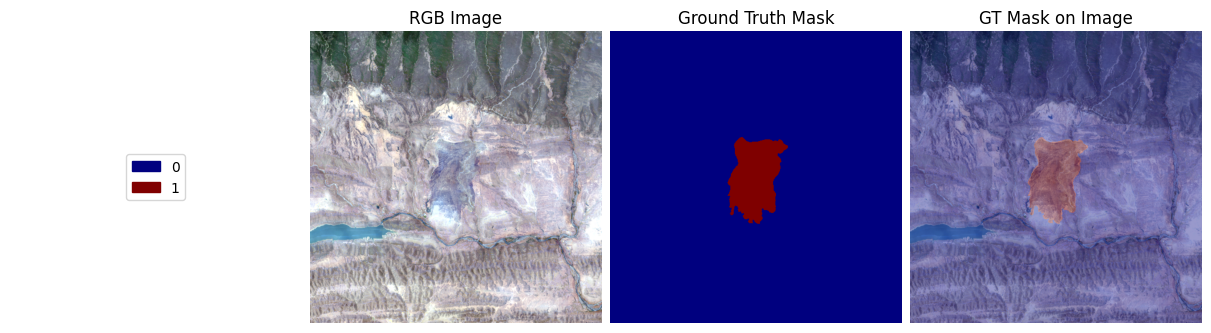

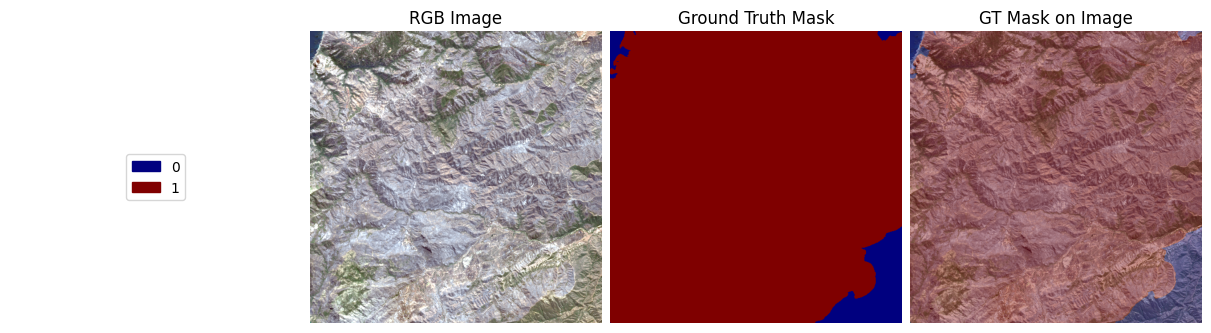

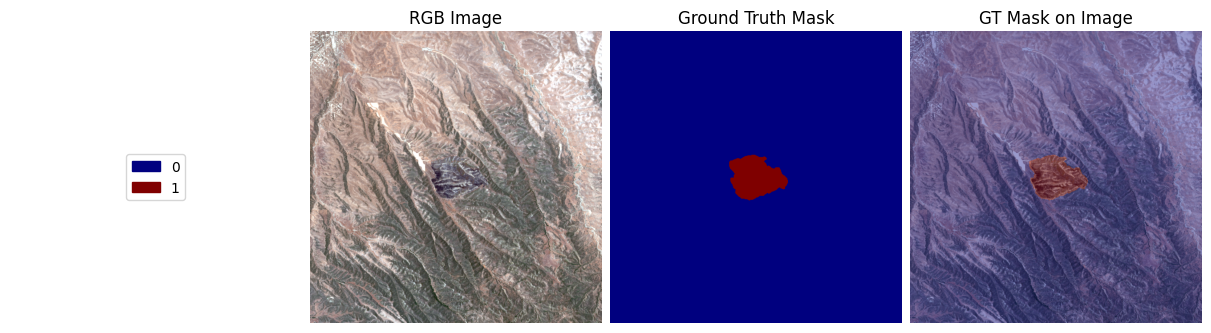

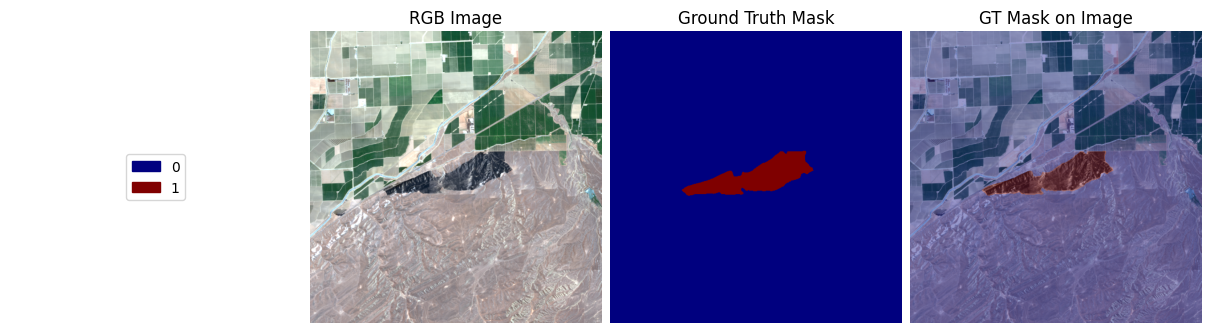

In [5]:
for i in range(4):
    _ = val_dataset.plot(train_dataset[i])

### Build training pipeline to finetune Prithvi

In [ ]:
from terratorch.tasks import SemanticSegmentationTask
import lightning.pytorch as pl

pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/burnscars/checkpoints/",
    monitor="val/mIoU",  # metric to monitor
    mode="max",
    filename="best-{epoch:02d}",
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1,                 # single device for notebook stability
    precision="bf16-mixed",    # speed up training
    num_nodes=1,
    logger=True,               # uses TensorBoard by default
    max_epochs=1,              # demo only
    log_every_n_steps=1,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="output/burnscars",
    detect_anomaly=True,
)

# Model
model = SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # Backbone
        "backbone": "prithvi_eo_v2_300",  # prithvi_eo_v1_100 / prithvi_eo_v2_300 / *_tl / *_600
        "backbone_pretrained": True,
        "backbone_num_frames": 1,
        "backbone_img_size": 512,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        # "backbone_coords_encoding": ["time", "location"],

        # Necks
        "necks": [
            {
                "name": "SelectIndices",
                # "indices": [2, 5, 8, 11],   # prithvi_eo_v1_100
                "indices": [5, 11, 17, 23],   # prithvi_eo_v2_300
                # "indices": [7, 15, 23, 31], # prithvi_eo_v2_600
            },
            {"name": "ReshapeTokensToImage"},
            {"name": "LearnedInterpolateToPyramidal"},
        ],

        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],

        # Head
        "head_dropout": 0.1,
        "num_classes": 2,
    },
    loss="ce",
    optimizer="AdamW",
    lr=1e-4,
    ignore_index=-1,
    freeze_backbone=True, # speed up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
    class_names=["no burned", "burned"],
)

In [ ]:
# Training
trainer.fit(model, datamodule=datamodule)

### Evaluate model and inference

In [ ]:
best_ckpt_path = "output/burnscars/checkpoints/best-epoch=00.ckpt"

# Evaluate the model on the test set
_ = trainer.test(model=model, datamodule=datamodule, ckpt_path=best_ckpt_path)

In [ ]:
import torch

# Normalization statistics
means = [0.0333497067415863,
        0.0570118552053618,
        0.0588974813200132,
        0.2323245113436119,
        0.1972854853760658,
        0.1194491422518656]

stds = [0.0226913556882377,
        0.0268075602230702,
        0.0400410984436278,
        0.0779173242367269,
        0.0870873883814014,
        0.0724197947743781]

test_loader = datamodule.test_dataloader()

with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"].to(model.device)

    # Apply the same normalization used during training
    mean = torch.tensor(means, device=images.device, dtype=images.dtype).view(1, -1, 1, 1)
    std = torch.tensor(stds, device=images.device, dtype=images.dtype).view(1, -1, 1, 1)
    images_norm = (images - mean) / std

    outputs = model(images_norm)
    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

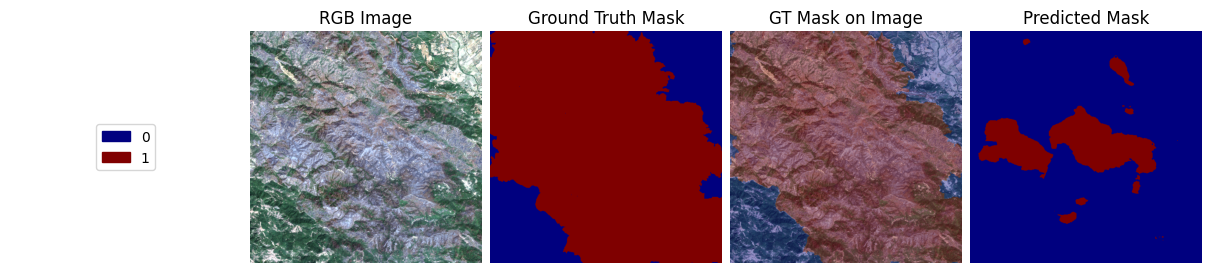

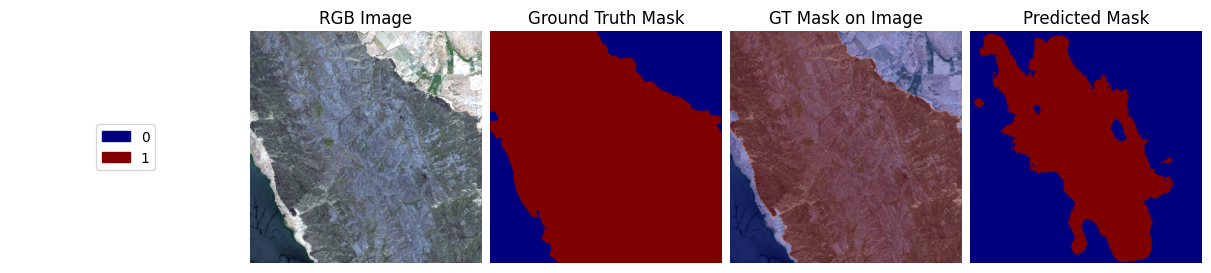

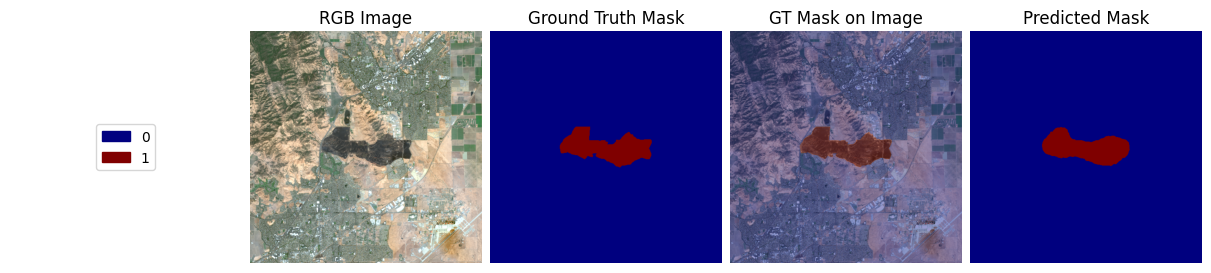

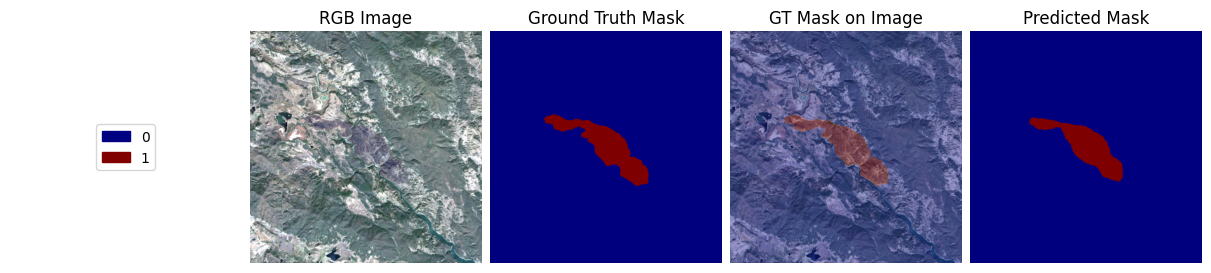

In [9]:
# Visualize a few predictions
test_dataset = datamodule.test_dataset

for i in range(4):
    sample = {key: batch[key][i] for key in batch}
    sample["image"] = sample["image"].cpu()
    sample["mask"] = sample["mask"].cpu()
    sample["prediction"] = preds[i]

    test_dataset.plot(sample)

In [ ]:
import os
best_ckpt_100_epoch_path = "burnscars_best-epoch=69.ckpt"

if not os.path.isfile(best_ckpt_100_epoch_path):
    gdown.download("https://drive.google.com/uc?id=1-I_DiiO2T1mjBTi3OAJaVeRWKHtAG63N")

# Evaluate the model on the test set
_ = trainer.test(model=model, datamodule=datamodule, ckpt_path=best_ckpt_100_epoch_path)

In [ ]:
import torch

# Normalization statistics
means = [0.0333497067415863,
        0.0570118552053618,
        0.0588974813200132,
        0.2323245113436119,
        0.1972854853760658,
        0.1194491422518656]

stds = [0.0226913556882377,
        0.0268075602230702,
        0.0400410984436278,
        0.0779173242367269,
        0.0870873883814014,
        0.0724197947743781]

test_loader = datamodule.test_dataloader()

with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"].to(model.device)

    # Apply the same normalization used during training
    mean = torch.tensor(means, device=images.device, dtype=images.dtype).view(1, -1, 1, 1)
    std = torch.tensor(stds, device=images.device, dtype=images.dtype).view(1, -1, 1, 1)
    images_norm = (images - mean) / std

    outputs = model(images_norm)
    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

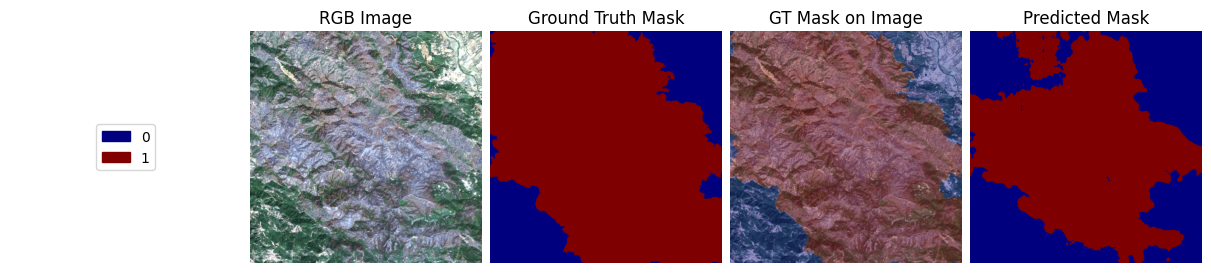

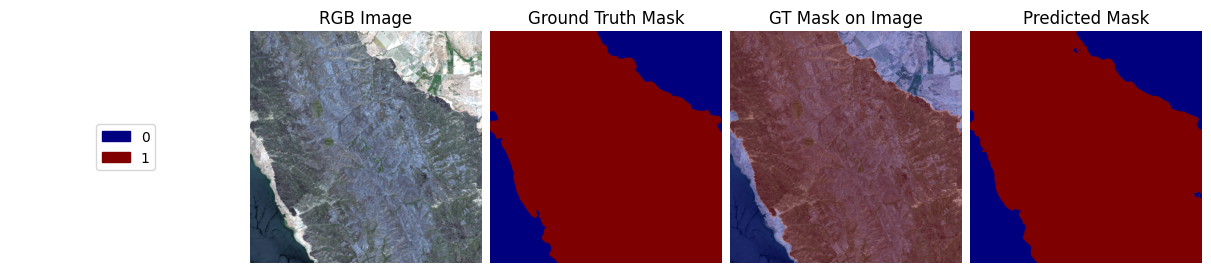

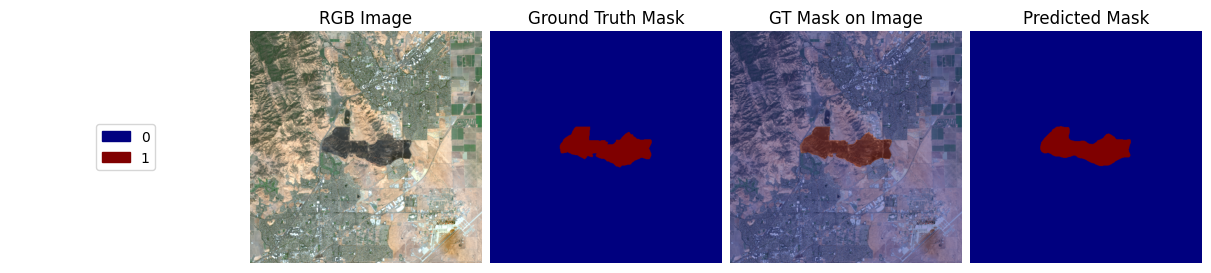

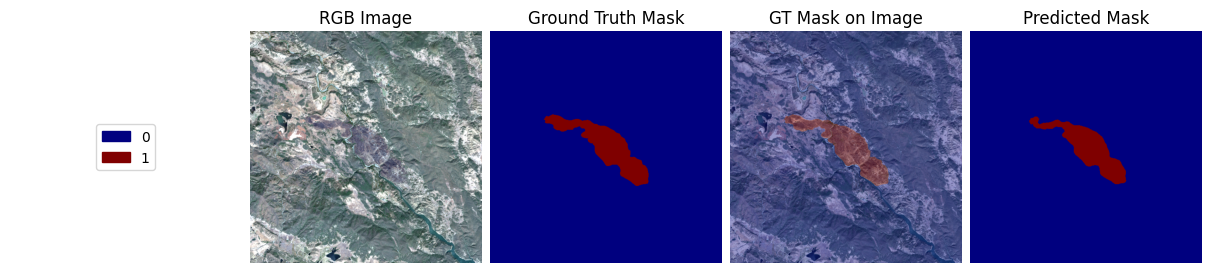

In [14]:
# Visualize a few predictions
test_dataset = datamodule.test_dataset

for i in range(4):
    sample = {key: batch[key][i] for key in batch}
    sample["image"] = sample["image"].cpu()
    sample["mask"] = sample["mask"].cpu()
    sample["prediction"] = preds[i]

    test_dataset.plot(sample)

## Fine-tuning via CLI

The example folder contains two Burnscars sample config files. The first reproduces the workflow above using a Prithvi backbone, while the second uses a UNet encoder-decoder via the `SMPModelFactory`.

Before running the CLI examples, it can be helpful to restart the session to free up GPU memory.


In [ ]:
!terratorch fit -c prithvi_v2_eo_300_tl_unet_burnscars.yaml

In [ ]:
!terratorch fit -c burnscars_smp.yaml